In [74]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import datetime
import joblib
import time

In [75]:
file_path = 'car-manual-dataset/simulation-dataset.csv'
df = pd.read_csv(file_path)
#load a mannually generated dataset

print("Load dateset successful")
#df.info()
print("\nShowing first 5 lines:")
print(df.head())

Load dateset successful

Showing first 5 lines:
   run_id  time_step    d_front     d_back   v_front    v_back  ego_a
0       0          0  45.849370  22.924685  0.000000  0.000000    0.0
1       0          1  45.828807  22.945248 -0.411258  0.411258    3.0
2       0          2  45.769777  23.004278 -0.769341  0.769341    3.0
3       0          3  45.667066  23.106988 -1.284869  1.284869    3.0
4       0          4  45.525153  23.248901 -1.553389  1.553389    3.0


In [76]:
def classify_acceleration(a, threshold=0.05):
    if a > threshold:
        return 2  # speed up
    elif a < -threshold:
        return 0  # slow down
    else:
        return 1  # stay

# transfer the acceleration from -1.5, 0, 1.5 to class 0,1,2
df['action'] = df['ego_a'].apply(classify_acceleration)
print(df['action'].value_counts())

#define model input and output
FEATURE_COLUMNS = ['d_front', 'd_back', 'v_front', 'v_back']
LABEL_COLUMN = 'action'

X = df[FEATURE_COLUMNS].values
y = df[LABEL_COLUMN].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24,stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)
test_dataset = test_dataset.batch(32)
                                

print(f"TrainSet scale: {len(X_train_scaled)}")
print(f"TestSet scale: {len(X_test_scaled)}")

action
1    9362
2     412
0     236
Name: count, dtype: int64
TrainSet scale: 8008
TestSet scale: 2002


In [89]:
# Simply using Katya's code, with output layer changed
def get_model(input_size, num_classes):

    # initializer = tf.keras.initializers.GlorotUniform(seed=42)
    
    # model = Sequential([
    #         Input(shape=(input_size,), name='input_features'),
    #         Dense(32, activation='relu', kernel_initializer=initializer, name='dense_1'),
    #         Dense(num_classes, activation='softmax', kernel_initializer=initializer, name='output_layer')
    #     ])
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_size,), name='input_features'),
            tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer, name='dense_1'),
            tf.keras.layers.Dense(num_classes, activation='linear', kernel_initializer=initializer, name='output_layer')
        ])
    print(model.summary())
    
    return model

In [90]:
# Train the model
num_classes = len(np.unique(y_train))
input_size = X_train_scaled.shape[1]
# train_dataset = X_train_scaled
epochs = 10


optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

model_base = get_model(input_size, num_classes)
model_base.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_fn])
model_base.fit(
    # X_train_scaled,
    # y_train, 
    train_dataset,
    epochs=epochs, 
    # batch_size = 32,
    validation_data=test_dataset
)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515 (2.01 KB)

 Trainable params: 515 (2.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 0.4393 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.2619 - val_sparse_categorical_accuracy: 0.9351
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.2370 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.2061 - val_sparse_categorical_accuracy: 0.9376
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.2004 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.1799 - val_sparse_categorical_accuracy: 0.9441
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.1807 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.1648 - val_sparse_categorical_accuracy: 0.9481
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 0.1686 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.1552 - val_sparse_categorical_accuracy: 0.9525
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.1607 - sparse_categorical_accuracy: 0.9454 - val_loss: 0.1522 - val_sparse_categorical_accu

In [91]:
# Visalization, copied from Katya
def print_metrics(model, x, y, c):
    # Get predicted probabilities for all classes
    y_pred_prob = model.predict(x)

    # Get predicted class labels (highest probability class)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # Calculate precision, recall, and F1-score (using macro average)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(c))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(c):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    # Plot the ROC curve for each class
    plt.figure(figsize=(6, 5))
    for i in range(c):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Precision (macro): 0.9549
Recall (macro): 0.5145
F1-score (macro): 0.5754


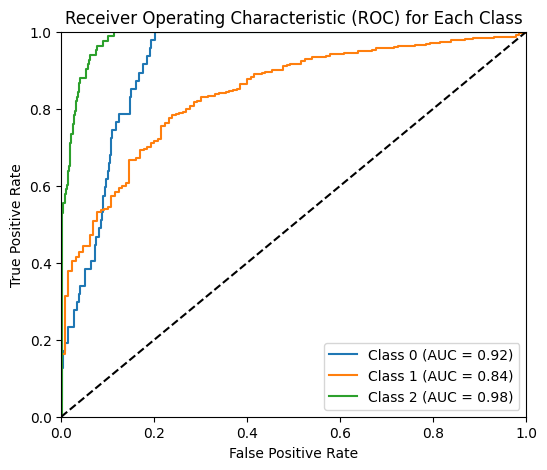

In [92]:
print_metrics(model_base, X_test_scaled, y_test, num_classes)

In [93]:
# Save the trained model, if you like
model_folder = 'nn-models'
os.makedirs(model_folder, exist_ok=True)
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'nn_model_{timestamp_str}.keras'
model_path = os.path.join(model_folder, model_filename)
scaler_filename = f'scaler_{timestamp_str}.pkl'
scaler_path = os.path.join(model_folder,scaler_filename)
# joblib.dump(scaler,scaler_path)
# model_base.save(model_path)
# print(f"model saved to {model_path}")




In [94]:
def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """Perform PGD attack on a batch of images.
    
    Args:
        model: Trained Keras model.
        x: Input images (batch).
        y: True labels (batch).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of PGD iterations.

    Returns:
        Adversarial examples.
    """
    # Make a copy of the input to avoid modifying the original data
    x_adv = tf.identity(x)

    # Iterate PGD for num_iter steps
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)  # Watch x_adv for gradient computation
            predictions = model(x_adv)  # Forward pass
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)  # Loss w.r.t. true label

        # Compute the gradients of the loss w.r.t. the input
        gradients = tape.gradient(loss, x_adv)
        
        # Perform gradient ascent step in the direction that maximizes the loss
        perturbations = tf.sign(gradients)  # Use the sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # Update the adversarial example
        
        # Project the adversarial example to ensure it's within epsilon-ball of the original image
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        
        # Ensure the adversarial examples are within the valid input range [0, 1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    
    return x_adv

def original_vs_adversarial_images(x_og, y_og, x_adv, y_pred):
    plt.figure(figsize=(17, 4))

    # Counter for how many images to display
    display_count = 0

    for i in range(len(x_og)):
        # Check if the class changes after the attack
        if y_og[i] != y_pred[i]:
            # Original images (reshape from (28, 28, 1) to (28, 28))
            original_image = x_og[i].reshape(28, 28)
            
            # Adversarial images (reshape from (28, 28, 1) to (28, 28))
            adversarial_image = x_adv[i].numpy().reshape(28, 28)

            # Plot original images
            plt.subplot(2, 10, display_count + 1)
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Orig: {y_og[i]}')

            # Plot adversarial images
            plt.subplot(2, 10, display_count + 11)
            plt.imshow(adversarial_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Adv: {y_pred[i]}')

            # Increment the display counter
            display_count += 1
            
            # Stop after displaying 10 images
            if display_count == 10:
                break

    plt.tight_layout()
    plt.show()

In [95]:
epsilon = 0.8
alpha = 0.3
num_iter = 10

# Test the PGD attack
x_test_sample = X_test_scaled
y_test_sample = y_test

# Generate adversarial examples
x_test_adv = pgd_attack(model_base, x_test_sample, y_test_sample, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv = np.argmax(model_base.predict(x_test_adv), axis=1)
accuracy_adv = np.mean(y_pred_adv == y_test_sample)

print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')
# print_metrics(model_base, x_test_adv, y_test_sample, num_classes)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
Accuracy on adversarial examples: 0.9351


In [96]:
def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.
    
    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.
    
    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
                
                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Forward pass
                logits = model(combined_x, training=True)
                
                # Compute the loss
                loss = loss_fn(combined_y, logits)
            
            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()

        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")
    
    return model

In [97]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_adv = get_model(input_size, num_classes)
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515 (2.01 KB)

 Trainable params: 515 (2.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
Train loss: 0.0984 -|- Train acc: 0.9023 -|- Test acc: 0.9351 -|- Time: 9.62s
Epoch 2/10
Train loss: 0.0670 -|- Train acc: 0.9356 -|- Test acc: 0.9351 -|- Time: 9.09s
Epoch 3/10
Train loss: 0.4309 -|- Train acc: 0.9367 -|- Test acc: 0.9431 -|- Time: 9.25s
Epoch 4/10
Train loss: 0.4231 -|- Train acc: 0.9383 -|- Test acc: 0.9441 -|- Time: 9.29s
Epoch 5/10
Train loss: 0.3981 -|- Train acc: 0.9389 -|- Test acc: 0.9456 -|- Time: 9.93s
Epoch 6/10
Train loss: 0.3796 -|- Train acc: 0.9391 -|- Test acc: 0.9446 -|- Time: 9.31s
Epoch 7/10
Train loss: 0.4354 -|- Train acc: 0.9397 -|- Test acc: 0.9491 -|- Time: 9.35s
Epoch 8/10
Train loss: 0.0491 -|- Train acc: 0.9400 -|- Test acc: 0.9491 -|- Time: 9.61s
Epoch 9/10
Train loss: 0.0888 -|- Train acc: 0.9402 -|- Test acc: 0.9476 -|- Time: 9.41s
Epoch 10/10
Train loss: 0.3594 -|- Train acc: 0.9406 -|- Test acc: 0.9525 -|- Time: 9.40s


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
Precision (macro): 0.9520
Recall (macro): 0.4954
F1-score (macro): 0.5512


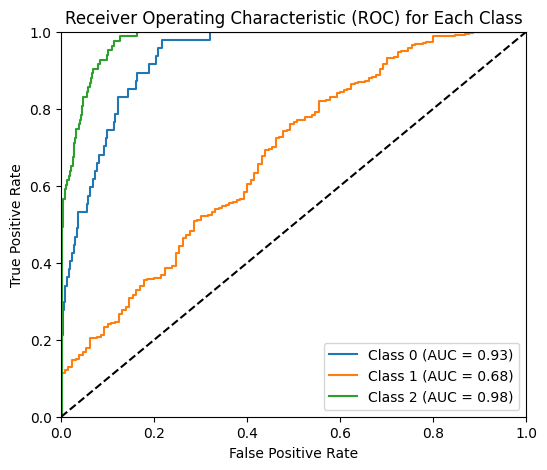

In [86]:
print_metrics(model_adv, X_test_scaled, y_test, num_classes)

In [98]:
# Test the PGD attack
x_test_sample_ADV = X_test_scaled
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
# print_metrics(model_adv, x_test_adv_ADV, y_test_sample_ADV, num_classes)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
Accuracy on adversarial examples: 0.9351


In [100]:
# Save the trained model, if you like
model_folder = 'nn-models'
os.makedirs(model_folder, exist_ok=True)
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'nn_model_adv_{timestamp_str}.keras'
model_path = os.path.join(model_folder, model_filename)
# scaler_filename = f'scaler_{timestamp_str}.pkl'
# scaler_path = os.path.join(model_folder,scaler_filename)
# joblib.dump(scaler,scaler_path)
# model_base.save(model_path)
# print(f"model saved to {model_path}")


